# Consensus Analysis of iForest output

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam
import logomaker
from tqdm import tqdm

# add parent folder of the C_to_U_classifier_plus_min package to path in order to be loaded into the current session
sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl, compute_apobec1_signature_pvalue, predict_editing_custom_thrs

Matplotlib is building the font cache; this may take a moment.


In [2]:
def produce_consensus(df, title, interval, ref_filepath):
    with tqdm(total=df.shape[0]) as pbar:
        refs = []
        ref = pysam.FastaFile(ref_filepath)
        for site in df.itertuples():
            region = site[1]
            pos1based = site[2]
            pos0based = pos1based-1
            strand = site[3]
            reference = ref.fetch(region, pos0based-interval, pos0based+interval+1)
            if strand == "+":
                refs.append(list(reference))
            elif strand == "-":
                reference = get_rev_compl(reference)
                refs.append(list(reference))
            pbar.update(1)
    ref.close()
    
    refs = pd.DataFrame(refs, columns=[f"{i}" for i in range(interval*2+1)])
    refs_freqs = {}
    for rel_pos in refs:
        refs_freqs[int(rel_pos)] = refs[rel_pos].value_counts().sort_index()
    refs = pd.DataFrame(refs_freqs).fillna(0)
    depths = refs.sum().tolist()
    refs = refs / depths
    refs = refs.T

    create_sequence_logo(refs, title=f"{title}")

In [3]:
# define inputs
ref_mm39_filepath = "/lustre/bio_running/C_to_U_editing/refs/GRCm39.primary_assembly.genome.fa"
wt_dfCTaggr_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.model_iForestcc1_pretrained_results/df_CT_predicted_aggregated.tsv"
ko_dfCTaggr_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.model_iForestcc1_pretrained_results/df_CT_predicted_aggregated.tsv"

## WT

In [4]:
wt_dfCTaggr = pd.read_table(wt_dfCTaggr_filepath)
wt_dfCTaggr = wt_dfCTaggr.query("depth_stranded > 50")
wt_dfCTaggr = predict_editing_custom_thrs(wt_dfCTaggr, 
                                          "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc1_cc2_merged.iforest.freq_thresholds.tsv",
                                          ref_mm39_filepath,
                                          0.02)
wt_dfCTaggr

100%|██████████| 382443/382443 [01:00<00:00, 6331.61it/s] 


,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat
0,chr1,4846611,-,2,0,100,0.020000,0.0,GTCTG,0
1,chr1,4846619,-,1,0,101,0.009901,0.0,AGCTT,0
2,chr1,4846635,-,5,0,77,0.064935,0.0,TTCTT,0
3,chr1,4846643,-,3,0,103,0.029126,0.0,CACAT,0
4,chr1,4846645,-,3,0,103,0.029126,0.0,TGCAC,0
...,...,...,...,...,...,...,...,...,...,...
389965,chrY,90804626,+,2,0,66,0.030303,0.0,AGCGG,0
389966,chrY,90804632,+,1,0,67,0.014925,0.0,CGCCG,0
389967,chrY,90804649,+,1,0,58,0.017241,0.0,CTCTG,0
389968,chrY,90804680,+,2,0,60,0.033333,0.0,CTCCA,0


100%|██████████| 382443/382443 [00:04<00:00, 79118.48it/s]
findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.
100%|██████████| 17402/17402 [00:00<00:00, 83229.50it/s]


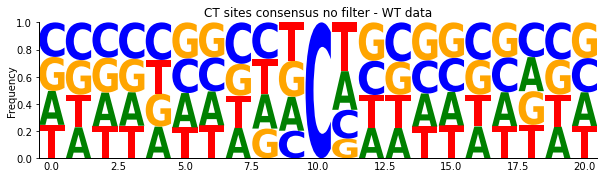

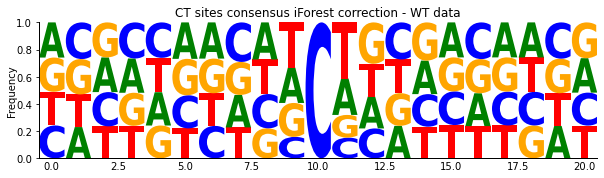

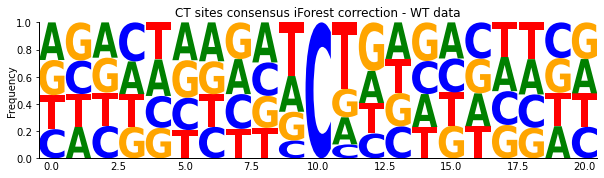

In [5]:
produce_consensus(wt_dfCTaggr, "CT sites consensus no filter - WT data", 10, ref_mm39_filepath)
produce_consensus(wt_dfCTaggr.query("Tfreq_corrected > 0"), "CT sites consensus iForest correction - WT data", 10, ref_mm39_filepath)
produce_consensus(wt_dfCTaggr.query("y_hat == 1"), "CT sites consensus iForest correction - WT data", 10, ref_mm39_filepath)

In [6]:
p_values = []
with tqdm(total=wt_dfCTaggr.shape[0]) as pbar:
    for s in wt_dfCTaggr.itertuples():
        p_values.append(compute_apobec1_signature_pvalue(ref_mm39_filepath, s[1], s[2], s[3]))
        pbar.update(1)

100%|██████████| 382443/382443 [51:04<00:00, 124.78it/s] 


In [7]:
wt_dfCTaggr["p_value"] = p_values
wt_dfCTaggr

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4846611,-,2,0,100,0.020000,0.0,GTCTG,0,1.0
1,chr1,4846619,-,1,0,101,0.009901,0.0,AGCTT,0,1.0
2,chr1,4846635,-,5,0,77,0.064935,0.0,TTCTT,0,1.0
3,chr1,4846643,-,3,0,103,0.029126,0.0,CACAT,0,1.0
4,chr1,4846645,-,3,0,103,0.029126,0.0,TGCAC,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
389965,chrY,90804626,+,2,0,66,0.030303,0.0,AGCGG,0,1.0
389966,chrY,90804632,+,1,0,67,0.014925,0.0,CGCCG,0,1.0
389967,chrY,90804649,+,1,0,58,0.017241,0.0,CTCTG,0,1.0
389968,chrY,90804680,+,2,0,60,0.033333,0.0,CTCCA,0,1.0


In [8]:
# save to disk
wt_dfCTaggr.to_csv("WT.df_CT_predicted_aggregated_iforest_apobec1_pvalues.tsv")

In [9]:
wt_dfCTaggr.query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
56,chr1,4847019,-,5,1,97,0.051546,0.010309,TTCTG,0,0.000631
68,chr1,4847867,-,1,0,125,0.008000,0.000000,TGCTG,0,0.000147
115,chr1,4915421,+,1,0,52,0.019231,0.000000,GTCTA,0,0.000108
116,chr1,4915426,+,2,2,51,0.039216,0.039216,TGCAT,1,0.001079
117,chr1,4915443,+,5,3,54,0.092593,0.055556,TACAA,1,0.000049
...,...,...,...,...,...,...,...,...,...,...,...
389413,chrX,165990174,-,18,6,4969,0.003622,0.001207,ATCAG,0,0.001171
389457,chrX,165990420,-,215,54,4664,0.046098,0.011578,AACTT,0,0.000113
389459,chrX,165990435,-,313,20,3917,0.079908,0.005106,TTCTT,0,0.003328
389460,chrX,165990438,-,66,18,4766,0.013848,0.003777,TACTT,0,0.000859


In [10]:
wt_dfCTaggr.query("Tfreq_native > 0.02").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
56,chr1,4847019,-,5,1,97,0.051546,0.010309,TTCTG,0,0.000631
116,chr1,4915426,+,2,2,51,0.039216,0.039216,TGCAT,1,0.001079
117,chr1,4915443,+,5,3,54,0.092593,0.055556,TACAA,1,0.000049
119,chr1,4915457,+,4,1,51,0.078431,0.019608,TACTA,0,0.000047
120,chr1,4915467,+,5,4,55,0.090909,0.072727,TACAG,1,0.005247
...,...,...,...,...,...,...,...,...,...,...,...
389202,chrX,161561752,+,15,1,132,0.113636,0.007576,CACTT,0,0.002286
389400,chrX,165638015,+,47,15,1259,0.037331,0.011914,CACTG,0,0.000217
389401,chrX,165638024,+,84,5,946,0.088795,0.005285,TTCTG,0,0.000144
389457,chrX,165990420,-,215,54,4664,0.046098,0.011578,AACTT,0,0.000113


In [11]:
wt_dfCTaggr.query("y_hat == 1").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
116,chr1,4915426,+,2,2,51,0.039216,0.039216,TGCAT,1,0.001079
117,chr1,4915443,+,5,3,54,0.092593,0.055556,TACAA,1,0.000049
120,chr1,4915467,+,5,4,55,0.090909,0.072727,TACAG,1,0.005247
136,chr1,4915694,+,7,4,51,0.137255,0.078431,TACTA,1,0.000521
140,chr1,4915760,+,2,2,58,0.034483,0.034483,GTCAA,1,0.009496
...,...,...,...,...,...,...,...,...,...,...,...
388552,chrX,154115400,-,9,4,125,0.072000,0.032000,TACTG,1,0.000807
388632,chrX,156228730,-,5,3,60,0.083333,0.050000,GACTT,1,0.002032
388737,chrX,158165691,+,6,4,125,0.048000,0.032000,ATCAA,1,0.000734
389040,chrX,161555202,+,23,10,124,0.185484,0.080645,GACTG,1,0.000465


100%|██████████| 11502/11502 [00:00<00:00, 74758.54it/s]


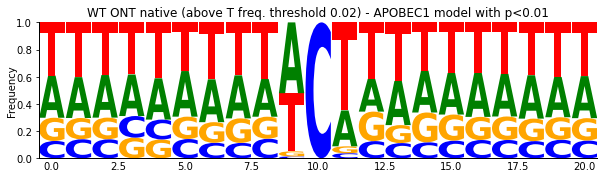

In [12]:
produce_consensus(wt_dfCTaggr.query("Tfreq_native > 0.02").query("p_value < 0.01"), "WT ONT native (above T freq. threshold 0.02) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

100%|██████████| 1595/1595 [00:00<00:00, 18925.70it/s]


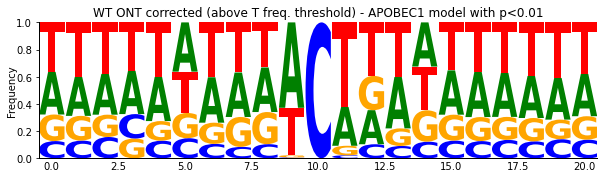

In [13]:
produce_consensus(wt_dfCTaggr.query("y_hat == 1").query("p_value < 0.01"), "WT ONT corrected (above T freq. threshold) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

## KO

In [14]:
ko_dfCTaggr = pd.read_table(ko_dfCTaggr_filepath)
ko_dfCTaggr = ko_dfCTaggr.query("depth_stranded > 50")
ko_dfCTaggr = predict_editing_custom_thrs(ko_dfCTaggr, 
                                          "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc1_cc2_merged.iforest.freq_thresholds.tsv",
                                          ref_mm39_filepath,
                                          0.02)
ko_dfCTaggr

100%|██████████| 518188/518188 [00:45<00:00, 11513.53it/s]


,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat
0,chr1,4846611,-,2,0,113,0.017699,0.000,GTCTG,0
1,chr1,4846619,-,2,0,121,0.016529,0.000,AGCTT,0
2,chr1,4846635,-,7,0,98,0.071429,0.000,TTCTT,0
3,chr1,4846643,-,2,1,125,0.016000,0.008,CACAT,0
4,chr1,4846645,-,4,1,125,0.032000,0.008,TGCAC,0
...,...,...,...,...,...,...,...,...,...,...
527697,chrY,90833612,+,3,0,54,0.055556,0.000,CGCCA,0
527698,chrY,90833626,+,3,0,56,0.053571,0.000,GACTG,0
527699,chrY,90833629,+,6,0,55,0.109091,0.000,TGCGT,0
527700,chrY,90833633,+,2,0,56,0.035714,0.000,TACAG,0


100%|██████████| 23587/23587 [00:00<00:00, 82778.41it/s]


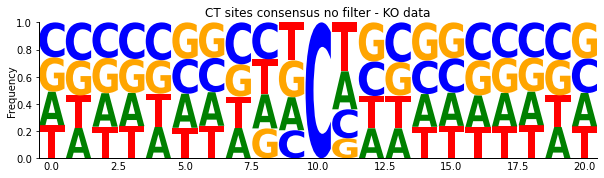

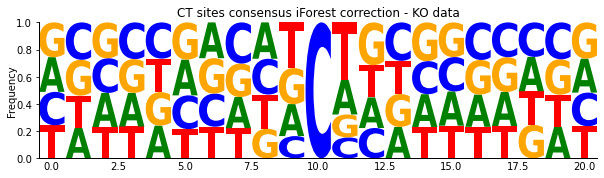

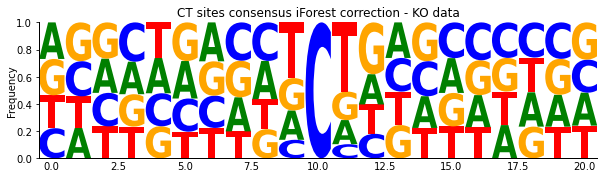

In [15]:
produce_consensus(ko_dfCTaggr, "CT sites consensus no filter - KO data", 10, ref_mm39_filepath)
produce_consensus(ko_dfCTaggr.query("Tfreq_corrected > 0"), "CT sites consensus iForest correction - KO data", 10, ref_mm39_filepath)
produce_consensus(ko_dfCTaggr.query("y_hat == 1"), "CT sites consensus iForest correction - KO data", 10, ref_mm39_filepath)

In [16]:
p_values = []
with tqdm(total=ko_dfCTaggr.shape[0]) as pbar:
    for s in ko_dfCTaggr.itertuples():
        p_values.append(compute_apobec1_signature_pvalue(ref_mm39_filepath, s[1], s[2], s[3]))
        pbar.update(1)

100%|██████████| 518188/518188 [1:10:33<00:00, 122.39it/s]


In [17]:
ko_dfCTaggr["p_value"] = p_values
ko_dfCTaggr

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4846611,-,2,0,113,0.017699,0.000,GTCTG,0,1.0
1,chr1,4846619,-,2,0,121,0.016529,0.000,AGCTT,0,1.0
2,chr1,4846635,-,7,0,98,0.071429,0.000,TTCTT,0,1.0
3,chr1,4846643,-,2,1,125,0.016000,0.008,CACAT,0,1.0
4,chr1,4846645,-,4,1,125,0.032000,0.008,TGCAC,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
527697,chrY,90833612,+,3,0,54,0.055556,0.000,CGCCA,0,1.0
527698,chrY,90833626,+,3,0,56,0.053571,0.000,GACTG,0,1.0
527699,chrY,90833629,+,6,0,55,0.109091,0.000,TGCGT,0,1.0
527700,chrY,90833633,+,2,0,56,0.035714,0.000,TACAG,0,1.0


In [18]:
# save to disk
ko_dfCTaggr.to_csv("KO.df_CT_predicted_aggregated_iforest_apobec1_pvalues.tsv")

In [19]:
ko_dfCTaggr.query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
65,chr1,4847019,-,14,1,114,0.122807,0.008772,TTCTG,0,0.000631
77,chr1,4847861,-,2,0,135,0.014815,0.000000,TACTT,0,0.000004
98,chr1,4854178,-,2,0,140,0.014286,0.000000,GACAT,0,0.000012
149,chr1,4900535,+,5,0,68,0.073529,0.000000,TTCTT,0,0.009068
190,chr1,4911270,+,6,0,74,0.081081,0.000000,TACTG,0,0.003523
...,...,...,...,...,...,...,...,...,...,...,...
527146,chrY,1028463,+,4,0,57,0.070175,0.000000,TTCAA,0,0.000567
527154,chrY,1028544,+,2,0,53,0.037736,0.000000,TTCTT,0,0.000380
527155,chrY,1028565,+,2,0,56,0.035714,0.000000,TACTC,0,0.000185
527156,chrY,1028567,+,4,1,55,0.072727,0.018182,CTCTA,0,0.004871


In [20]:
ko_dfCTaggr.query("Tfreq_native > 0.02").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
65,chr1,4847019,-,14,1,114,0.122807,0.008772,TTCTG,0,0.000631
149,chr1,4900535,+,5,0,68,0.073529,0.000000,TTCTT,0,0.009068
190,chr1,4911270,+,6,0,74,0.081081,0.000000,TACTG,0,0.003523
212,chr1,4915358,+,4,1,71,0.056338,0.014085,TACAT,0,0.000933
213,chr1,4915362,+,2,0,75,0.026667,0.000000,TACCA,0,0.000476
...,...,...,...,...,...,...,...,...,...,...,...
527144,chrY,1028455,+,5,1,56,0.089286,0.017857,ATCTG,0,0.002682
527146,chrY,1028463,+,4,0,57,0.070175,0.000000,TTCAA,0,0.000567
527154,chrY,1028544,+,2,0,53,0.037736,0.000000,TTCTT,0,0.000380
527155,chrY,1028565,+,2,0,56,0.035714,0.000000,TACTC,0,0.000185


In [21]:
ko_dfCTaggr.query("y_hat == 1").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
287,chr1,4916168,+,13,2,96,0.135417,0.020833,AACTG,1,0.001260
306,chr1,4916319,+,9,2,87,0.103448,0.022989,TTCTT,1,0.000316
309,chr1,4916336,+,25,7,104,0.240385,0.067308,GCCGA,1,0.000316
460,chr1,4963782,+,12,3,90,0.133333,0.033333,TACAC,1,0.001785
529,chr1,4967134,+,8,2,96,0.083333,0.020833,TTCTT,1,0.001192
...,...,...,...,...,...,...,...,...,...,...,...
526198,chrX,156228730,-,5,3,68,0.073529,0.044118,GACTT,1,0.002032
526345,chrX,158168406,+,13,6,164,0.079268,0.036585,ATCTA,1,0.001369
526600,chrX,161552918,+,9,5,175,0.051429,0.028571,AACAC,1,0.005402
526772,chrX,161561670,+,21,6,218,0.096330,0.027523,AACTG,1,0.001552


100%|██████████| 12834/12834 [00:00<00:00, 51141.20it/s]


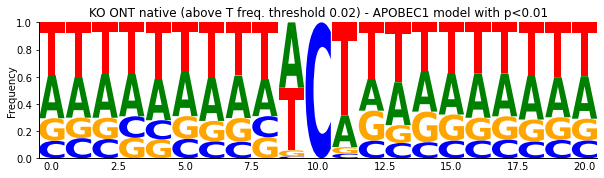

In [22]:
produce_consensus(ko_dfCTaggr.query("Tfreq_native > 0.02").query("p_value < 0.01"), "KO ONT native (above T freq. threshold 0.02) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

100%|██████████| 1156/1156 [00:00<00:00, 35763.08it/s]


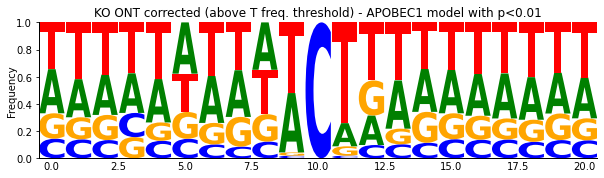

In [23]:
produce_consensus(ko_dfCTaggr.query("y_hat == 1").query("p_value < 0.01"), "KO ONT corrected (above T freq. threshold) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

In [27]:
wt_dfCTaggr.query("p_value < 0.01").query("position == 121983223")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
199419,chr2,121983223,+,105,48,895,0.117318,0.053631,CACAT,1,0.00448
